# Main Idea:
We are going to train each model on two different classes, making a binary classification problem, then we will use liquid
democracy to delegate the the model that is the best on the test set at a given time.

In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from scipy import stats

In [133]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation and load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load MNIST dataset
mnist_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

In [134]:
# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output classes for MNIST digits

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

    def predict(self, x):
        logits = self.forward(x)
        return torch.argmax(logits, dim=1)

    def predict_proba(self, x):
        logits = self.forward(x)
        return torch.softmax(logits, dim=1)

In [135]:
# we will now define 20 different models, each with different random initializations
models = [Net().to(device) for i in range(10)]

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

# prepare the data loaders
# Get indices of training samples based on the label

In [136]:
# Prepare the data loaders
def prepare_loaders():
    # Get indices of training samples based on the label
    train_indices_01 = [
        i for i, label in enumerate(mnist_train.targets) if label == 0 or label == 1
    ]
    train_indices_23 = [
        i for i, label in enumerate(mnist_train.targets) if label == 2 or label == 3
    ]
    train_indices_45 = [
        i for i, label in enumerate(mnist_train.targets) if label == 4 or label == 5
    ]
    train_indices_67 = [
        i for i, label in enumerate(mnist_train.targets) if label == 6 or label == 7
    ]
    train_indices_89 = [
        i for i, label in enumerate(mnist_train.targets) if label == 8 or label == 9
    ]

    # Create Subsets
    subset_train_01 = Subset(mnist_train, train_indices_01)
    subset_train_23 = Subset(mnist_train, train_indices_23)
    subset_train_45 = Subset(mnist_train, train_indices_45)
    subset_train_67 = Subset(mnist_train, train_indices_67)
    subset_train_89 = Subset(mnist_train, train_indices_89)

    # Create DataLoader for all subsets
    loader_train_01 = DataLoader(subset_train_01, batch_size=64, shuffle=True)
    loader_train_23 = DataLoader(subset_train_23, batch_size=64, shuffle=True)
    loader_train_45 = DataLoader(subset_train_45, batch_size=64, shuffle=True)
    loader_train_67 = DataLoader(subset_train_67, batch_size=64, shuffle=True)
    loader_train_89 = DataLoader(subset_train_89, batch_size=64, shuffle=True)

    return (
        loader_train_01,
        loader_train_23,
        loader_train_45,
        loader_train_67,
        loader_train_89,
    )

In [137]:
loader_01, loader_23, loader_45, loader_67, loader_89 = prepare_loaders()

In [138]:
def train_models():
    # Train the models
    for epoch in tqdm(range(5)):
        # Train each model 2 models on each subset
        # eg, model 0 and 1 will be trained on loader 01
        # model 2 and 3 will be trained on loader 23

        # Train models 0 and 1 on loader 01
        for model in [0, 1]:
            for images, labels in loader_01:
                images, labels = images.to(device), labels.to(device)
                optimizers[model].zero_grad()
                logits = models[model](images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizers[model].step()

        # Train models 2 and 3 on loader 23
        for model in [2, 3]:
            for images, labels in loader_23:
                images, labels = images.to(device), labels.to(device)
                optimizers[model].zero_grad()
                logits = models[model](images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizers[model].step()

        # Train models 4 and 5 on loader 45
        for model in [4, 5]:
            for images, labels in loader_45:
                images, labels = images.to(device), labels.to(device)
                optimizers[model].zero_grad()
                logits = models[model](images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizers[model].step()

        # Train models 6 and 7 on loader 67
        for model in [6, 7]:
            for images, labels in loader_67:
                images, labels = images.to(device), labels.to(device)
                optimizers[model].zero_grad()
                logits = models[model](images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizers[model].step()

        # Train models 8 and 9 on loader 89
        for model in [8, 9]:
            for images, labels in loader_89:
                images, labels = images.to(device), labels.to(device)
                optimizers[model].zero_grad()
                logits = models[model](images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizers[model].step()

In [139]:
train_models()

100%|██████████| 5/5 [03:01<00:00, 36.22s/it]


In [199]:
class Voter:
    def __init__(self, model, id):
        self.model = model
        self.id = id
        self.accuracy = []
        self.batch_accuracies = []
        self.CI = (0, 0)
        self.ucb_score = 0

    def partial_fit(self, X, y):
        self.model.partial_fit(X, y)

    def predict(self, X):
        predictions = self.model.predict(X)

        return predictions

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def __str__(self):
        return "Voter " + str(self.id)

    def __repr__(self):
        return "Voter " + str(self.id)


class DelegationMechanism:
    def __init__(self):
        self.delegations = {}  # key: delegate_from (id), value: delegate_to (id)
        self.t = 0

    def delegate(self, from_id, to_id):
        # cycles are impossible with this mechanism, so we don't need to check for them
        self.delegations[from_id] = to_id

    def wilson_score_interval(self, point_wise_accuracies, confidence=0.99999):
        ups = sum(point_wise_accuracies)
        downs = len(point_wise_accuracies) - ups
        n = len(point_wise_accuracies)

        # use the specified confidence value to calculate the z-score
        z = stats.norm.ppf(1 - (1 - confidence) / 2)
        p = ups / n

        left = p + 1 / (2 * n) * z * z
        right = z * np.sqrt(p * (1 - p) / n + z * z / (4 * n * n))
        under = 1 + 1 / n * z * z

        return ((left - right) / under, (left + right) / under)

    def ucb(self, voter, t, c=3.0):
        point_wise_accuracies = voter.accuracy

        mean = np.mean(point_wise_accuracies)

        n_t = len(point_wise_accuracies)

        fudge_factor = 1e-8

        ucb = mean + np.sqrt(c * np.log(t) / (n_t + fudge_factor))

        return ucb

    def calculate_CI(self, voter):
        point_wise_accuracies = voter.accuracy

        # assume the point wise accuracies are a list of bernoulli random variables
        # approximate using the Wilson score interval
        return self.wilson_score_interval(point_wise_accuracies)

    def update_delegations(self, voters):
        # first, we need to recalculate the CI for each voter
        for voter in voters:
            voter.ucb_score = self.ucb(voter, self.t)

        # now we need to do two things:
        # 1. ensure all current delegations are still valid. If not, remove them
        # 2. go through the full delegation process
        delegators_to_pop = []
        for (
            delegator,
            delegee,
        ) in self.delegations.items():  # check delegations and break invalid ones
            if delegator.ucb_score > delegee.ucb_score:
                delegators_to_pop.append(delegator)
        for delegator in delegators_to_pop:
            self.delegations.pop(delegator)

        for voter in voters:  # go through the full delegation process
            possible_delegees = []
            gaps = []
            for other_voter in voters:
                # find all other voters who have a higher ucb score
                if other_voter.id != voter.id and (
                    other_voter.ucb_score > voter.ucb_score
                ):
                    possible_delegees.append(other_voter)
                    gaps.append(other_voter.ucb_score - voter.ucb_score)
            if len(possible_delegees) > 0:
                # probabilistically delegate based on the gaps
                # larger gaps are more likely to be chosen
                sum_gaps = sum(gaps)
                probabilities = [gap / sum_gaps for gap in gaps]
                delegee = np.random.choice(possible_delegees, p=probabilities)
                self.delegate(voter, delegee)

    def get_gurus(self, voters):
        # find all voters who have not delegated to anyone
        gurus = []
        for voter in voters:
            if voter not in self.delegations.keys():
                gurus.append(voter)
        return gurus

In [165]:
# We will now use all of these models as an ensemble to classify the test set
# We will use a majority vote to classify each image
# We will keep track of the accuracy of the ensemble on each batch of the dataset

# put labels 0-4 at the start of the test set
# put labels 5-9 at the end of the test set
# this way we simulate covariate shift

# # Get indices of training samples based on the label
# test_inidices_01 = [i for i, label in enumerate(mnist_test.targets) if label == 0 or label == 1]
# test_inidices_23 = [i for i, label in enumerate(mnist_test.targets) if label == 2 or label == 3]
# test_inidices_45 = [i for i, label in enumerate(mnist_test.targets) if label == 4 or label == 5]
# test_inidices_67 = [i for i, label in enumerate(mnist_test.targets) if label == 6 or label == 7]
# test_inidices_89 = [i for i, label in enumerate(mnist_test.targets) if label == 8 or label == 9]

# # Create Subsets
# subset_test_01 = Subset(mnist_test, test_inidices_01)
# subset_test_23 = Subset(mnist_test, test_inidices_23)
# subset_test_45 = Subset(mnist_test, test_inidices_45)
# subset_test_67 = Subset(mnist_test, test_inidices_67)
# subset_test_89 = Subset(mnist_test, test_inidices_89)

# # Create DataLoader for all subsets
# loader_test_01 = DataLoader(subset_test_01, batch_size=10, shuffle=True)
# loader_test_23 = DataLoader(subset_test_23, batch_size=10, shuffle=True)
# loader_test_45 = DataLoader(subset_test_45, batch_size=10, shuffle=True)
# loader_test_67 = DataLoader(subset_test_67, batch_size=10, shuffle=True)
# loader_test_89 = DataLoader(subset_test_89, batch_size=10, shuffle=True)

# # print a sample of the subset_test_04
# print("Sample of subset_test_04")
# for images, labels in loader_test_01:
#     print(images.shape)
#     print(labels.shape)
#     print(labels)
#     break

# # append both loaders together
# loader_test_01 = list(loader_test_01)
# loader_test_23 = list(loader_test_23)
# loader_test_45 = list(loader_test_45)
# loader_test_67 = list(loader_test_67)
# loader_test_89 = list(loader_test_89)


# test_loader = loader_test_01 + loader_test_23 + loader_test_45 + loader_test_67 + loader_test_89

# test_indices_04 = [i for i, label in enumerate(mnist_test.targets) if label <= 4]
# test_indices_59 = [i for i, label in enumerate(mnist_test.targets) if label >= 5]

# subset_test_04 = Subset(mnist_test, test_indices_04)
# subset_test_59 = Subset(mnist_test, test_indices_59)

# loader_test_04 = DataLoader(subset_test_04, batch_size=32, shuffle=True)
# loader_test_59 = DataLoader(subset_test_59, batch_size=32, shuffle=True)

# loader_test_04 = list(loader_test_04)
# loader_test_59 = list(loader_test_59)

# test_loader = loader_test_04 + loader_test_59

test_indices_04 = [i for i, label in enumerate(mnist_test.targets) if label <= 4]
test_indices_59 = [i for i, label in enumerate(mnist_test.targets) if label >= 5]

subset_test_04 = Subset(mnist_test, test_indices_04)
subset_test_59 = Subset(mnist_test, test_indices_59)

loader_test_04 = DataLoader(subset_test_04, batch_size=32, shuffle=True)
loader_test_59 = DataLoader(subset_test_59, batch_size=32, shuffle=True)

loader_test_04 = list(loader_test_04)
loader_test_59 = list(loader_test_59)

test_loader = loader_test_04 + loader_test_59

In [166]:
voters = []

UCBs_over_time = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

for i in range(len(models)):
    voters.append(Voter(models[i], i))

delegation_mechanism = DelegationMechanism()

liquid_dem_proba_accs = []
liquid_dem_vote_accs = []
liquid_dem_weighted_vote_accs = []
full_ensembel_accs = []

# Warm start
# # Take some small random samples from the test set and use them to warm start the delegation mechanism
# for i in range(1000):
#     # get a random sample from the test set
#     rand_idx = np.random.randint(0, len(mnist_test))
#     data, target = mnist_test[rand_idx]

#     # get all of the voters to to predict and update thier accuracies and CIs
#     for voter in voters:
#         predictions = voter.predict(data)
#         point_wise_accuracies = (predictions == target).float().tolist()
#         voter.accuracy.extend(point_wise_accuracies)
#         voter.CI = delegation_mechanism.calculate_CI(voter)


for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)

    gurus = delegation_mechanism.get_gurus(voters)
    # print(len(gurus))
    # print()
    for guru in gurus:
        # print(guru.CI)
        predictions = guru.predict(data)

        # print(predictions.shape)
        # print(predictions)
        # print(target.shape)

        point_wise_accuracies = (predictions == target).float().tolist()
        guru.accuracy.extend(point_wise_accuracies)

        guru.batch_accuracies.append(
            sum(point_wise_accuracies) / len(point_wise_accuracies)
        )

    # get all of the gurus to predict then take the majority vote
    liquid_dem_preds = []
    for guru in gurus:
        guru_pred = guru.predict(data)

        # find number of delegations
        guru_weight = 0
        for delegator, delegee in delegation_mechanism.delegations.items():
            if delegee == guru.id:
                guru_weight += 1
        if guru_weight == 0:
            guru_weight = 1
        for i in range(guru_weight):
            liquid_dem_preds.append(guru_pred)

    liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
    # take the majority vote
    liquid_dem_preds = torch.mode(liquid_dem_preds, dim=1)[0]
    liquid_dem_weighted_vote_accs.append(
        (liquid_dem_preds == target).float().mean().item()
    )

    # get all of the gurus to predict then take the majority vote
    liquid_dem_preds = []
    for guru in gurus:
        liquid_dem_preds.append(guru.predict(data))
    liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
    # take the majority vote
    liquid_dem_preds = torch.mode(liquid_dem_preds, dim=1)[0]
    liquid_dem_vote_accs.append((liquid_dem_preds == target).float().mean().item())

    probas = []
    for guru in gurus:
        probas.append(guru.predict_proba(data))
    probas = torch.stack(probas).transpose(0, 1)
    # take the average
    probas = torch.mean(probas, dim=1)
    # take the highest probability
    liquid_dem_preds = torch.argmax(probas, dim=1)
    liquid_dem_proba_accs.append((liquid_dem_preds == target).float().mean().item())

    # # get every voter to predict and extend their accuracies
    # for voter in voters:
    #     predictions = voter.predict(data)
    #     point_wise_accuracies = (predictions == target).float().tolist()
    #     voter.accuracy.extend(point_wise_accuracies)

    # get all of the models to predict then take the majority vote
    full_ensemble_preds = []
    for model in models:
        full_ensemble_preds.append(model.predict(data))
    full_ensemble_preds = torch.stack(full_ensemble_preds).transpose(0, 1)
    # take the majority vote
    full_ensemble_preds = torch.mode(full_ensemble_preds, dim=1)[0]
    full_ensembel_accs.append((full_ensemble_preds == target).float().mean().item())

    # print(delegation_mechanism.delegations)

    # add the CIs to the dictionary
    for voter in voters:
        UCBs_over_time[voter.id].append(voter.ucb_score)

    delegation_mechanism.t += len(data)

    delegation_mechanism.update_delegations(voters)

    # print(delegation_mechanism.delegations)
    # print()

    # print()
    # print("Gurus: ", gurus)
    # print()
    # for guru in gurus:
    # print(guru.CI, end=" ")

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:01<00:00, 218.10it/s]


In [167]:
print(delegation_mechanism.delegations)

{Voter 2: Voter 7, Voter 3: Voter 9, Voter 1: Voter 7, Voter 4: Voter 7, Voter 5: Voter 7, Voter 0: Voter 8, Voter 6: Voter 8, Voter 7: Voter 8, Voter 9: Voter 8}


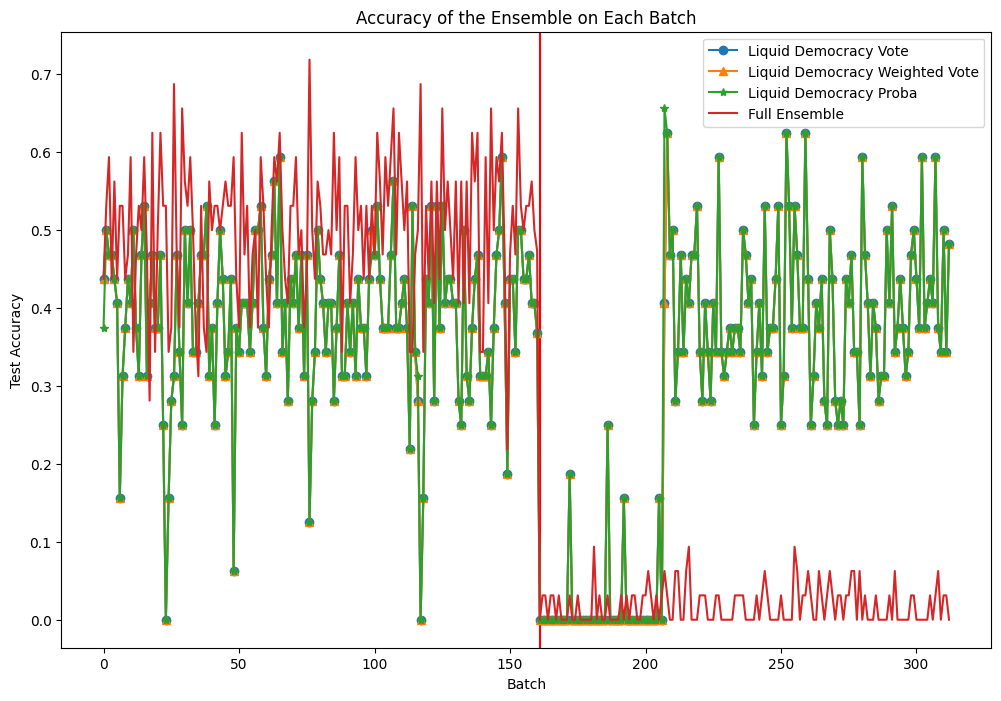

In [168]:
# plot the accuracy of the ensemble on each batch

split = len(loader_test_04)
# split_23 = len(loader_test_01) + len(loader_test_23)
# split_45 = len(loader_test_01) + len(loader_test_23) + len(loader_test_45)
# split_67 = len(loader_test_01) + len(loader_test_23) + len(loader_test_45) + len(loader_test_67)
# split_89 = len(loader_test_01) + len(loader_test_23) + len(loader_test_45) + len(loader_test_67) + len(loader_test_89)

plt.figure(figsize=(12, 8))

# plt.axvline(x=split_01, color="r")
# plt.axvline(x=split_23, color="r")
# plt.axvline(x=split_45, color="r")
# plt.axvline(x=split_67, color="r")
# plt.axvline(x=split_89, color="r")

plt.axvline(x=split, color="r")

plt.plot(liquid_dem_vote_accs, marker="o", label="Liquid Democracy Vote")
plt.plot(
    liquid_dem_weighted_vote_accs, marker="^", label="Liquid Democracy Weighted Vote"
)
plt.plot(liquid_dem_proba_accs, marker="*", label="Liquid Democracy Proba")
plt.plot(full_ensembel_accs, label="Full Ensemble")
plt.xlabel("Batch")
plt.ylabel("Test Accuracy")
plt.title("Accuracy of the Ensemble on Each Batch")
plt.legend()
plt.show()

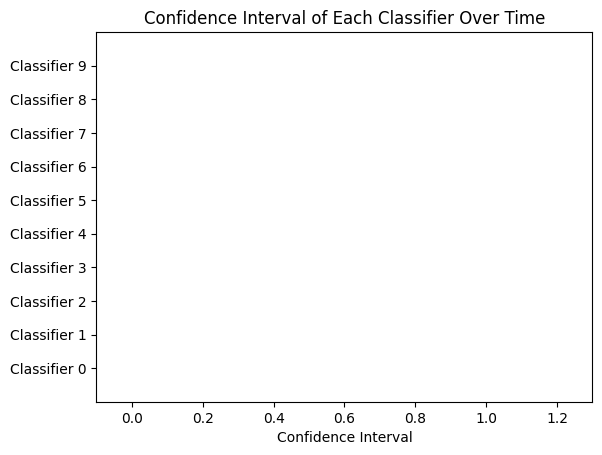

In [169]:
# Number of classifiers and time steps
num_classifiers = len(UCBs_over_time)
num_timesteps = len(UCBs_over_time[0])

# Initialize figure and axis
fig, ax = plt.subplots()

# Set labels and title
ax.set_xlabel("Confidence Interval")
ax.set_title("Confidence Interval of Each Classifier Over Time")

# Set y-ticks to show classifier labels and adjust plot limits
ax.set_yticks(range(num_classifiers))
ax.set_yticklabels([f"Classifier {i}" for i in range(num_classifiers)])
ax.set_xlim(-0.1, 1.3)
ax.set_ylim(-1, num_classifiers)

# Create a list to hold the line objects for each classifier
lines = [ax.plot([], [], "o-", lw=2)[0] for _ in range(num_classifiers)]


# Function to initialize the animation
def init():
    for line in lines:
        line.set_data([], [])
    return lines


# Function to update the plot for each frame
def update(frame):
    for classifier, line in enumerate(lines):
        ucb_score = UCBs_over_time[classifier][frame]
        line.set_data([ucb_score], [classifier])
    return lines


# Create the animation
anim = FuncAnimation(
    fig, update, frames=num_timesteps, init_func=init, blit=True, interval=25
)

plt.show()

In [170]:
anim.save("ci_animation.gif", writer="pillow")

- Would be nice to try some form of the UCB with a sliding window to see if we can get better results. The exploration bonus gets weaker as time goes on which could be annoying
- I also want to try other methods of ensembling aside from majority vote, like averaging the probabilities or something like that
- Could also try actually using the delgation weights to weight the models predictions

In [185]:
import random
def custom_majority_vote(predictions):
    """
    Custom majority vote function that handles ties by choosing randomly.
    """
    result = []
    for preds in predictions:
        unique, counts = preds.unique(return_counts=True)
        max_count = counts.max()
        # Find all values that are tied for the most frequent
        candidates = unique[counts == max_count]
        if len(candidates) > 1:
            # Randomly select among the candidates in case of a tie
            result.append(random.choice(candidates.tolist()))
        else:
            # Otherwise, just append the most frequent value
            result.append(candidates[0].item())
    return torch.tensor(result)

100%|██████████| 313/313 [00:04<00:00, 76.87it/s]


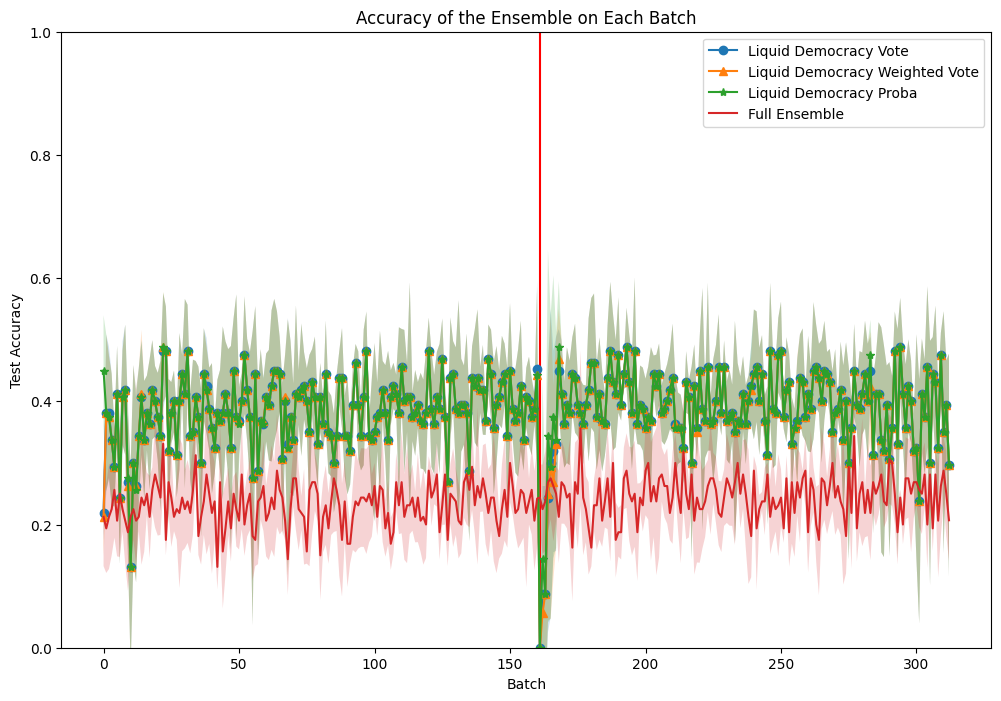

In [204]:
num_experiments = 5

all_liquid_dem_vote_accs = []
all_liquid_dem_weighted_vote_accs = []
all_liquid_dem_proba_accs = []
all_full_ensembel_accs = []

for i in range(num_experiments):
    test_indices_04 = [i for i, label in enumerate(mnist_test.targets) if label <= 4]
    test_indices_59 = [i for i, label in enumerate(mnist_test.targets) if label >= 5]

    subset_test_04 = Subset(mnist_test, test_indices_04)
    subset_test_59 = Subset(mnist_test, test_indices_59)

    loader_test_04 = DataLoader(
        subset_test_04,
        batch_size=32,
        shuffle=True,
    )
    loader_test_59 = DataLoader(
        subset_test_59,
        batch_size=32,
        shuffle=True,
    )

    loader_test_04 = list(loader_test_04)
    loader_test_59 = list(loader_test_59)

    test_loader = loader_test_04 + loader_test_59

    voters = [Voter(model, i) for i, model in enumerate(models)]
    delegation_mechanism = DelegationMechanism()

    liquid_dem_proba_accs = []
    liquid_dem_vote_accs = []
    liquid_dem_weighted_vote_accs = []
    full_ensembel_accs = []

    # No warm start

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)

        gurus = delegation_mechanism.get_gurus(voters)
        # print(len(gurus))
        # print()
        for guru in gurus:
            # print(guru.CI)
            predictions = guru.predict(data)

            # print(predictions.shape)
            # print(predictions)
            # print(target.shape)

            point_wise_accuracies = (predictions == target).float().tolist()
            guru.accuracy.extend(point_wise_accuracies)

            guru.batch_accuracies.append(
                sum(point_wise_accuracies) / len(point_wise_accuracies)
            )

        # get all of the gurus to predict then take the majority vote
        liquid_dem_preds = []
        for guru in gurus:
            guru_pred = guru.predict(data)

            # find number of delegations
            guru_weight = 0
            for delegator, delegee in delegation_mechanism.delegations.items():
                if delegee == guru.id:
                    guru_weight += 1
            if guru_weight == 0:
                guru_weight = 1
            for i in range(guru_weight):
                liquid_dem_preds.append(guru_pred)

        liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
        # take the majority vote
        liquid_dem_preds = custom_majority_vote(liquid_dem_preds)
        liquid_dem_weighted_vote_accs.append(
            (liquid_dem_preds == target).float().mean().item()
        )

        # get all of the gurus to predict then take the majority vote
        liquid_dem_preds = []
        for guru in gurus:
            liquid_dem_preds.append(guru.predict(data))
        liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
        # take the majority vote
        liquid_dem_preds = custom_majority_vote(liquid_dem_preds)
        liquid_dem_vote_accs.append((liquid_dem_preds == target).float().mean().item())

        probas = []
        for guru in gurus:
            probas.append(guru.predict_proba(data))
        probas = torch.stack(probas).transpose(0, 1)
        # take the average
        probas = torch.mean(probas, dim=1)
        # take the highest probability
        liquid_dem_preds = torch.argmax(probas, dim=1)

        liquid_dem_proba_accs.append((liquid_dem_preds == target).float().mean().item())

        # get all of the models to predict then take the majority vote
        full_ensemble_preds = []
        for model in models:
            full_ensemble_preds.append(model.predict(data))
        full_ensemble_preds = torch.stack(full_ensemble_preds).transpose(0, 1)
        # Apply the custom majority vote
        full_ensemble_preds = custom_majority_vote(full_ensemble_preds)

        full_ensembel_accs.append((full_ensemble_preds == target).float().mean().item())

        # print(delegation_mechanism.delegations)

        # add the CIs to the dictionary
        for voter in voters:
            UCBs_over_time[voter.id].append(voter.ucb_score)

        delegation_mechanism.t += len(data)

        delegation_mechanism.update_delegations(voters)

    all_liquid_dem_vote_accs.append(liquid_dem_vote_accs)
    all_liquid_dem_weighted_vote_accs.append(liquid_dem_weighted_vote_accs)
    all_liquid_dem_proba_accs.append(liquid_dem_proba_accs)
    all_full_ensembel_accs.append(full_ensembel_accs)

all_liquid_dem_vote_accs = np.array(all_liquid_dem_vote_accs)
all_liquid_dem_weighted_vote_accs = np.array(all_liquid_dem_weighted_vote_accs)
all_liquid_dem_proba_accs = np.array(all_liquid_dem_proba_accs)
all_full_ensembel_accs = np.array(all_full_ensembel_accs)

liquid_dem_vote_accs_mean = np.mean(all_liquid_dem_vote_accs, axis=0)
liquid_dem_vote_accs_std = np.std(all_liquid_dem_vote_accs, axis=0)

liquid_dem_weighted_vote_accs_mean = np.mean(all_liquid_dem_weighted_vote_accs, axis=0)
liquid_dem_weighted_vote_accs_std = np.std(all_liquid_dem_weighted_vote_accs, axis=0)

liquid_dem_proba_accs_mean = np.mean(all_liquid_dem_proba_accs, axis=0)
liquid_dem_proba_accs_std = np.std(all_liquid_dem_proba_accs, axis=0)

full_ensembel_accs_mean = np.mean(all_full_ensembel_accs, axis=0)
full_ensembel_accs_std = np.std(all_full_ensembel_accs, axis=0)

split = len(loader_test_04)

plt.figure(figsize=(12, 8))

plt.axvline(x=split, color="r")

plt.plot(liquid_dem_vote_accs_mean, marker="o", label="Liquid Democracy Vote")
plt.fill_between(
    range(len(liquid_dem_vote_accs_mean)),
    liquid_dem_vote_accs_mean - liquid_dem_vote_accs_std,
    liquid_dem_vote_accs_mean + liquid_dem_vote_accs_std,
    alpha=0.2,
)

plt.plot(
    liquid_dem_weighted_vote_accs_mean,
    marker="^",
    label="Liquid Democracy Weighted Vote",
)
plt.fill_between(
    range(len(liquid_dem_weighted_vote_accs_mean)),
    liquid_dem_weighted_vote_accs_mean - liquid_dem_weighted_vote_accs_std,
    liquid_dem_weighted_vote_accs_mean + liquid_dem_weighted_vote_accs_std,
    alpha=0.2,
)

plt.plot(liquid_dem_proba_accs_mean, marker="*", label="Liquid Democracy Proba")
plt.fill_between(
    range(len(liquid_dem_proba_accs_mean)),
    liquid_dem_proba_accs_mean - liquid_dem_proba_accs_std,
    liquid_dem_proba_accs_mean + liquid_dem_proba_accs_std,
    alpha=0.2,
)

plt.plot(full_ensembel_accs_mean, label="Full Ensemble")
plt.fill_between(
    range(len(full_ensembel_accs_mean)),
    full_ensembel_accs_mean - full_ensembel_accs_std,
    full_ensembel_accs_mean + full_ensembel_accs_std,
    alpha=0.2,
)

plt.xlabel("Batch")
plt.ylabel("Test Accuracy")

# set lower y limit to 0
plt.ylim(0, 1)

plt.title("Accuracy of the Ensemble on Each Batch")
plt.legend()
plt.show()

In [205]:
# print the number of batches where the proba method outperformed all other methods
print(
    "Number of batches where the proba method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(liquid_dem_proba_accs_mean))
            if liquid_dem_proba_accs_mean[i] > liquid_dem_vote_accs_mean[i]
            and liquid_dem_proba_accs_mean[i] > liquid_dem_weighted_vote_accs_mean[i]
            and liquid_dem_proba_accs_mean[i] > full_ensembel_accs_mean[i]
        ]
    ),
)

# print the number of batches where the vote method outperformed all other methods
print(
    "Number of batches where the vote method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(liquid_dem_vote_accs_mean))
            if liquid_dem_vote_accs_mean[i] > liquid_dem_proba_accs_mean[i]
            and liquid_dem_vote_accs_mean[i] > liquid_dem_weighted_vote_accs_mean[i]
            and liquid_dem_vote_accs_mean[i] > full_ensembel_accs_mean[i]
        ]
    ),
)

# print the number of batches where the weighted vote method outperformed all other methods
print(
    "Number of batches where the weighted vote method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(liquid_dem_weighted_vote_accs_mean))
            if liquid_dem_weighted_vote_accs_mean[i] > liquid_dem_proba_accs_mean[i]
            and liquid_dem_weighted_vote_accs_mean[i] > liquid_dem_vote_accs_mean[i]
            and liquid_dem_weighted_vote_accs_mean[i] > full_ensembel_accs_mean[i]
        ]
    ),
)

# print the number of batches where the full ensemble method outperformed all other methods
print(
    "Number of batches where the full ensemble method outperformed all other methods: ",
    sum(
        [
            1
            for i in range(len(full_ensembel_accs_mean))
            if full_ensembel_accs_mean[i] > liquid_dem_proba_accs_mean[i]
            and full_ensembel_accs_mean[i] > liquid_dem_vote_accs_mean[i]
            and full_ensembel_accs_mean[i] > liquid_dem_weighted_vote_accs_mean[i]
        ]
    ),
)

Number of batches where the proba method outperformed all other methods:  7
Number of batches where the vote method outperformed all other methods:  6
Number of batches where the weighted vote method outperformed all other methods:  3
Number of batches where the full ensemble method outperformed all other methods:  6
